In [65]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [66]:
class MoneyAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.wealth = 1
    
    def move(self):
        possible_cells = self.model.grid.get_neighborhood( self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_cells)
        self.model.grid.move_agent(self, new_position)
    
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [67]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = len(model.schedule.agents)
    B = sum( xi * (N-i) for i, xi in enumerate(x) ) / (N * sum(x))
    return (1 + (1/N) - 2*B)

In [68]:
class MoneyModel(Model):
    def __init__(self, num_agents, width, height):
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            model_reporters = {"Gini": compute_gini},
            agent_reporters = {"Wealth": "wealth"}
        )
        for i in range(num_agents):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [69]:
NUM_AGENTS = 100
WIDTH = 20
HEIGHT = 20
STEPS = 50

model = MoneyModel(NUM_AGENTS, WIDTH, HEIGHT)
for i in range(STEPS):
    model.step()

(array([47., 31., 13.,  0.,  3.,  1.,  0.,  1.,  3.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

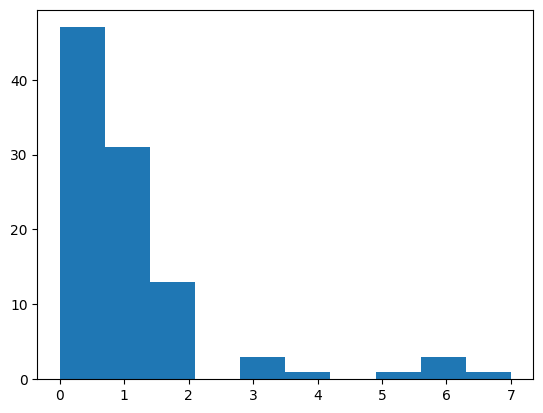

In [70]:
agent_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agent_wealth)

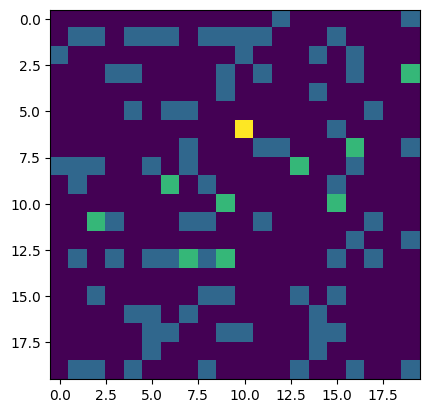

In [71]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    (cell_content, (x, y)) = cell
    agent_counts[x][y] = len(cell_content)

plt.imshow(agent_counts, interpolation='nearest')

<Axes: >

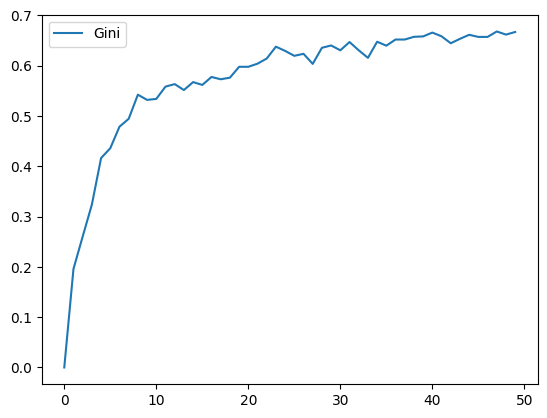

In [73]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [72]:
all_wealth = []
for i in range(100):
    model = MoneyModel(10)
    for j in range(10):
        model.step()
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

TypeError: MoneyModel.__init__() missing 2 required positional arguments: 'width' and 'height'